In [1]:
import glob
import gc
from collections import OrderedDict
import datetime
from pathlib import Path

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras

np.set_printoptions(precision=4, suppress=True)

print('tensorflow', tf.__version__)
print(tf.config.list_physical_devices('GPU'))

tensorflow 2.15.0-rc0
[]


In [2]:
######### SELECT THE DATASET #########
# DATASET = 'Syncan'
DATASET = 'X-CANIDS'

if DATASET == 'Syncan':
    DATASET_DIR = f"../../Dataset/{DATASET}"
    data_files = {
        'train': [
            f'{DATASET_DIR}/train_train.csv',
            # f'{DATASET_DIR}/train_train{i+1:02}.csv' for i in range(10)   # train_train01~10.csv
        ],
        'valid': [
            f'{DATASET_DIR}/train_valid.csv'
        ],
        'test': [
            f'{DATASET_DIR}/test_normal.csv',
            f'{DATASET_DIR}/test_flooding.csv',
            f'{DATASET_DIR}/test_plateau.csv',
            f'{DATASET_DIR}/test_continuous.csv',
            f'{DATASET_DIR}/test_playback.csv',
            f'{DATASET_DIR}/test_suppress.csv'
        ]
    }
elif DATASET == 'X-CANIDS':
    DATASET_DIR = f"../../Dataset/{DATASET}/canet"
    NSIG = '107'
    data_files = {
        'train': glob.glob(f'{DATASET_DIR}/sig{NSIG}_dump[1-4].parquet'),
        'valid': [f'{DATASET_DIR}/sig{NSIG}_dump5.parquet'],
        'test': glob.glob(f'{DATASET_DIR}/sig{NSIG}_dump6_*.parquet')
    }

In [3]:
def syncan_divide_train_valid(train_data_path: str, valid_prop=0.05):
    df = pd.read_csv(train_data_path)
    r = len(df)
    r_valid = int(r * valid_prop)
    df_train = df.iloc[:r-r_valid]
    df_train.to_csv(f'{train_data_path[:-4]}_train.csv', index=False)
    df_val = df.iloc[r-r_valid:]
    df_val.to_csv(f'{train_data_path[:-4]}_valid.csv', index=False)
    print(f'{Path(train_data_path).name} is divided into train_train.csv and train_valid.csv.')

def str_to_list(data_str: str) -> list:
    data_list_str = data_str.split()
    data_list = [int(x) for x in data_list_str]
    if len(data_list) < 8:  # fill with dummy values (0) to 8 bytes
        data_list += [0] * (8 - len(data_list))
    return data_list

def load_arrange_data(file_path, dataset, print_option=True):
    df = pd.read_parquet(file_path)
    if dataset == 'X-CANIDS':
        df.reset_index(drop=True, inplace=True)
        df['ID'] = df['ID'].astype(str)
        if print_option:
            print(f'# rows: {df.shape[0]:,}')
            print(df['Session'].value_counts())
        return df
    elif dataset == 'Syncan':
        df['Time'] = round(df['Time'] / 1000, 7)     # milliseconds to seconds
        df.rename(columns={'Label': 'Session'}, inplace=True)
        if print_option:
            print(f'# rows: {df.shape[0]:,}')
            print(df['Session'].value_counts())
        return df

def get_count_features(data_df: pd.DataFrame, window_size_s: int, start_s=0) -> pd.DataFrame:
    data_df = data_df[['Time', 'ID']].copy()
    data_df['occur'] = 1
    data_df = pd.concat([data_df['Time'], data_df.pivot(columns='ID', values='occur')], axis=1)
    data_df['TimeIndex'] = pd.to_timedelta(data_df['Time'], unit='s')
    data_df.set_index('TimeIndex', inplace=True)
    count_df = data_df.drop(columns=['Time']).rolling(str(window_size_s)+'s').count()
    count_df = count_df.astype('int16')
    assert len(data_df) == len(count_df)
    real_start_s = count_df.index.min().seconds
    real_start_us = count_df.index.min().microseconds
    count_df = count_df.loc[count_df.index > pd.Timedelta(seconds=real_start_s + start_s, microseconds=real_start_us)]
    return count_df

In [4]:
# Divide train.csv of SynCAN into train set and validation set. We are using the last 5% of train.csv for validation.
if DATASET == 'Syncan':
    syncan_divide_train_valid(f'{DATASET_DIR}/train.csv', valid_prop=0.05)

# Prepare input data

In [5]:
WINDOW_SIZE = 1
TRAIN_START = WINDOW_SIZE + 1

### Frequencies and number of signals of CAN IDs

In [6]:
if DATASET == 'Syncan':
    ID_MPS = {'id1': 67, 'id10': 22, 'id2': 33, 'id3': 67, 'id4': 22, 'id5': 67, 'id6': 33, 'id7': 67, 'id8': 67, 'id9': 33}
    ID_NSIG = OrderedDict([('id1', 2), ('id10', 4), ('id2', 3), ('id3', 2), ('id4', 1), ('id5', 2), ('id6', 2), ('id7', 2), ('id8', 1), ('id9', 1)])
elif DATASET == 'X-CANIDS':
    ID_MPS = {'1151': 50, '1265': 50, '128': 100, '129': 100, '1292': 10, '1322': 10, '1345': 11, '1349': 10, '1351': 10, '1353': 10, '1363': 5, '1365': 10, '1366': 10, '1367': 10, '1419': 10, '1427': 5, '1440': 1, '1456': 1, '273': 100, '274': 100, '275': 100, '354': 100, '399': 100, '512': 100, '544': 100, '593': 100, '608': 100, '68': 1, '688': 100, '790': 100, '809': 100, '897': 50, '899': 50, '902': 50, '903': 50}
    ID_NSIG = OrderedDict([('1151', 1), ('1265', 3), ('128', 5), ('129', 3), ('1292', 2), ('1322', 1), ('1345', 3), ('1349', 4), ('1351', 2), ('1353', 4), ('1363', 4), ('1365', 1), ('1366', 5), ('1367', 2), ('1419', 5), ('1427', 4), ('1440', 1), ('1456', 1), ('273', 4), ('274', 3), ('275', 4), ('354', 3), ('399', 3), ('512', 1), ('544', 4), ('593', 2), ('608', 5), ('68', 2), ('688', 2), ('790', 6), ('809', 6), ('897', 1), ('899', 2), ('902', 4), ('903', 4)])

### Data input pipeline functions
Each CAN ID will have the different length of time steps and number of signals

In [7]:
def get_repeated_sequences(data, can_id, n_sig, n_step):
    sig_columns = [f'Signal{i}' for i in range(1, n_sig + 1)]
    df_id = data.loc[data['ID'] == can_id, ['Idx'] + sig_columns]
    np_sig = df_id[sig_columns].to_numpy()
    np_seq = np.lib.stride_tricks.sliding_window_view(np_sig, window_shape=n_step, axis=0)
    np_seq = np_seq.swapaxes(1, 2)
    n_seq = np_seq.shape[0]
    end_idx = data['Idx'].iloc[-1]
    n_repeats = np.diff(df_id['Idx'].to_list() + [end_idx])[-n_seq:]
    repeated_seq = np.repeat(np_seq, n_repeats, axis=0)
    return repeated_seq

def prepare_dataset(file_path, time_cutoff, label='last', print_option=True):
    assert label in ['last', 'sum', False]
    data = load_arrange_data(file_path, dataset=DATASET, print_option=False)
    data = data.reset_index(names='Idx')
    time_start = data['Time'].iloc[0]
    n_rows_to_use = data.loc[data['Time'] > time_start + time_cutoff, 'Time'].shape[0]
    if label == 'last':
        time_and_labels = data.loc[data['Time'] > time_start + time_cutoff, ['Time', 'Session']].to_numpy()
    data_dict = dict()
    for id, nsig in ID_NSIG.items():
        seq_data = get_repeated_sequences(data, id, nsig, ID_MPS[id])
        data_dict[id] = seq_data[-n_rows_to_use:].copy()
        if print_option:
            print(id, data_dict[id].shape)
    assert all([l == n_rows_to_use for l in map(len, data_dict.values())])
    if label:
        assert len(time_and_labels) == n_rows_to_use
        return data_dict, time_and_labels
    else:
        return data_dict

def load_inputs(data_path, time_cutoff, label, shuffle=True, seed=0):
    if not label:
        x_dict = prepare_dataset(data_path, time_cutoff=time_cutoff, label=False, print_option=False)
    else:
        x_dict, x_time_label = prepare_dataset(data_path, time_cutoff=time_cutoff, label=label, print_option=False)
    if shuffle:
        np.random.seed(seed)
        n_samples = len(x_dict[list(x_dict.keys())[0]])
        shuffled_idx = np.arange(n_samples)
        np.random.shuffle(shuffled_idx)
        x_dict = {id: seqs[shuffled_idx] for id, seqs in x_dict.items()}
        if label:
            x_time_label = x_time_label[shuffled_idx]
    y = np.concatenate([x_dict[id][:, -1, :] for id in FIXED_IDS], axis=1)
    if not label:
        return x_dict, y
    else:
        return x_dict, y, x_time_label

# Create CANet model

In [8]:
N_SIGS = sum([n_sig for n_sig in ID_NSIG.values()])
FIXED_IDS = list(ID_NSIG.keys())
FIXED_IDS.sort()

def create_canet_model(h):
    inputs = {id: keras.Input(shape=(ID_MPS[id], ID_NSIG[id]), name=id) for id in FIXED_IDS}
    lstms = [keras.layers.LSTM(h * ID_NSIG[id], name=f'lstm_{id}') for id in FIXED_IDS]
    x_id = [lstms[i](inputs[id]) for i, id in enumerate(FIXED_IDS)]
    x = keras.layers.Concatenate()(x_id)
    x = keras.layers.Dense((h * N_SIGS) // 2, activation='elu')(x)
    x = keras.layers.Dense(N_SIGS - 1, activation='elu')(x)
    outputs = keras.layers.Dense(N_SIGS, activation='elu')(x)
    return keras.Model(inputs, outputs)

In [9]:
# Create the model
h = 5
lr = 0.0001 # learning rate
model = create_canet_model(h)
optimizer = keras.optimizers.Adam(learning_rate=lr)
model.compile(
    optimizer=optimizer,
    loss='mean_squared_error'
)

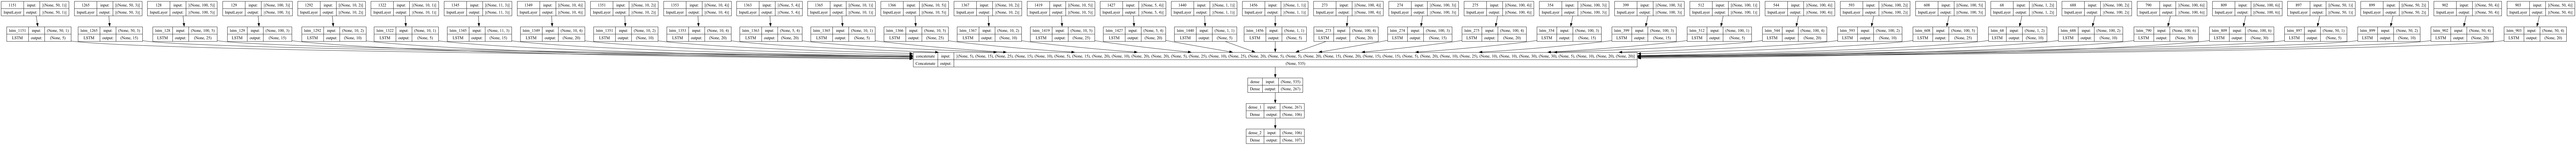

In [10]:
# (Optional) If you want to plot the model
# pip install pydot
# install graphviz (see instructions at https://graphviz.gitlab.io/download/)
keras.utils.plot_model(model, show_shapes=True)

# Train

In [11]:
def slice_data(file_path: str, n_sliced: int):
    if Path(file_path).suffix == '.csv':
        df = pd.read_csv(file_path)
    elif Path(file_path).suffix == '.parquet':
        df = pd.read_parquet(file_path)
    else:
        raise Exception(f'File type {file_path} not supported')
    p = len(df) // n_sliced
    split_indices = list(range(0, len(df) + 1, p))[:-1]
    paths = []
    for i in range(n_sliced):
        if i + 1 < n_sliced:
            sliced_df = df.iloc[split_indices[i]:split_indices[i+1]]
        else:  # the last slice
            sliced_df = df.iloc[split_indices[i]:]
        cache_dir = Path(file_path).parent / 'cache'
        cache_dir.mkdir(exist_ok=True)
        save_path = str(cache_dir / f'{Path(file_path).stem}_{i+1}.parquet')
        sliced_df.to_parquet(save_path)
        paths.append(save_path)
    return paths

In [12]:
# Train parameters
batch_size = 250
if DATASET == 'Syncan':
    n_epoch = 5
elif DATASET == 'X-CANIDS':
    n_epoch = 10

In [13]:
starttime = datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
for epoch in range(n_epoch):
    print(f'********** Epoch {epoch+1} **********')
    # Train the model
    for data_file in data_files['train']:
        sliced_files = slice_data(data_file, 10)  # When the data is too big to make inputs at once
        for sliced_file in sliced_files:
            x_train_dict, y_train = load_inputs(sliced_file, time_cutoff=TRAIN_START, label=False, shuffle=True, seed=epoch)
            print(f'Training with {sliced_file} {y_train.shape}')
            with tf.device('CPU'):
                train_ds = tf.data.Dataset.from_tensor_slices((x_train_dict, y_train))
            train_ds = train_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
            model.fit(train_ds, verbose=2)
            del x_train_dict, y_train, train_ds
            gc.collect()

    # Validate the model
    val_loss = 0
    for data_file in data_files['valid']:
        if DATASET == 'X-CANIDS':
            sliced_files = slice_data(data_file, 10)  # When the data is too big to make inputs at once
        else:
            sliced_files = slice_data(data_file, 1)
        for sliced_file in sliced_files:
            x_valid_dict, y_valid = load_inputs(sliced_file, time_cutoff=TRAIN_START, label=False, shuffle=False)
            gc.collect()
            print(f'Validating with {sliced_file} {y_valid.shape}')
            with tf.device('CPU'):
                valid_ds = tf.data.Dataset.from_tensor_slices((x_valid_dict, y_valid))
            valid_ds = valid_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
            val_loss += model.evaluate(valid_ds, verbose=2)
            del x_valid_dict, y_valid, valid_ds
            gc.collect()

    # save the model weight
    weight_name = f'../../models/CANET/{DATASET}_{starttime}_epoch{epoch+1:02}'
    model.save_weights(weight_name)

********** Epoch 1 **********
Training with ../../Dataset/X-CANIDS/canet/cache/sig107_dump4_1.parquet (392085, 107)
1569/1569 - 95s - loss: 0.0081 - 95s/epoch - 61ms/step
Training with ../../Dataset/X-CANIDS/canet/cache/sig107_dump4_2.parquet (392092, 107)
1569/1569 - 86s - loss: 0.0010 - 86s/epoch - 55ms/step
Training with ../../Dataset/X-CANIDS/canet/cache/sig107_dump4_3.parquet (392068, 107)
1569/1569 - 83s - loss: 4.0476e-04 - 83s/epoch - 53ms/step
Training with ../../Dataset/X-CANIDS/canet/cache/sig107_dump4_4.parquet (392085, 107)
1569/1569 - 86s - loss: 1.5061e-04 - 86s/epoch - 55ms/step
Training with ../../Dataset/X-CANIDS/canet/cache/sig107_dump4_5.parquet (392089, 107)
1569/1569 - 90s - loss: 3.3192e-04 - 90s/epoch - 57ms/step
Training with ../../Dataset/X-CANIDS/canet/cache/sig107_dump4_6.parquet (392068, 107)
1569/1569 - 89s - loss: 8.2565e-05 - 89s/epoch - 57ms/step
Training with ../../Dataset/X-CANIDS/canet/cache/sig107_dump4_7.parquet (392080, 107)
1569/1569 - 88s - loss

KeyboardInterrupt: 